Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says "YOUR ANSWER HERE" or `YOUR CODE HERE` and remove the `raise NotImplementedError()` lines. 

Code blocks starting with a `# tests` comment provide unit tests which have to run without errors in order to get full points. Be aware that there might be further 'secret' tests to check correct implementation! I.e. the provided unit tests are necessary but not sufficient for full points!

You are always welcome to add **additional plots, tests, or debug outputs**.
However, make sure to: **1) not break the automated tests**, and **2) switch off any excessive debug output** when you submit your notebook!
Note that there is a **hard limit of 720s for execution time** of individual cells when autograding!

Please add your name and student ID below:

In [2]:
NAME = "Konstantinos Vakalopoulos" 
STUDENT_ID = "12223236" 
# YOUR CODE HERE
# raise NotImplementedError()

In [3]:
assert len(NAME) > 0, "Enter your name!"
assert len(STUDENT_ID) > 0, "Enter your student ID!"

# Intelligent Audio and Music Analysis Assignment 6

This assignment accounts for 50 points of the 3rd and last assignment block (100 points total)

Assignment 6 and 7 are more free form than the previous assignments. The goal is to apply what has been practiced so far. For implementing assignments 6 and 7, follow the code structures from previous assignments and reuse as much code as possible. You can use any libraries, we recommend madmom, librosa, pyTorch, etc. (the libraries we have used so far).

## Semantic Music Tagging

Following the approach by [Choi et al. \[2016\]](https://arxiv.org/pdf/1606.00298.pdf) “Automatic Tagging Using Deep Convolutional Neural Networks”, a CNN architecture shall be implemented to predict semantic categories for short clips of music pieces. As suggested, for experiments, the MagnaTagATune dataset will be used.



### GPU Support
Our JupyterHub, unfortunately, does not yet provide GPU support. Nevertheless, this assignment can be run as-is on JupyterHub, however training of the neural network will take even longer than last time.

In order to speed up training if you are in a hurry, you can run this notebook on any local machine with GPU and cuda support, or alternatively use infrastructure like [google colab](https://colab.research.google.com/) and drive, if you have a google account.

Simply upload your solved notebook and output model file back to JupyterHub for your submission.

In [4]:
import os
# This code block enables this notebook to run on google colab.
try:
    from google.colab import drive
    print('Running in colab...\n===================')
    COLAB = True
    !pip install madmom librosa # torch==1.4.0 torchvision==0.5.0 --upgrade
    print('Installed dependencies!\n=======================')

    if not os.path.exists('audio'):
        print('Downloading data...\n===================')
        !wget https://mi.soi.city.ac.uk/datasets/magnatagatune/clip_info_final.csv --no-check-certificate
        !wget https://mi.soi.city.ac.uk/datasets/magnatagatune/annotations_final.csv --no-check-certificate
        !wget https://mi.soi.city.ac.uk/datasets/magnatagatune/mp3.zip.001 --no-check-certificate
        !wget https://mi.soi.city.ac.uk/datasets/magnatagatune/mp3.zip.002 --no-check-certificate
        !wget https://mi.soi.city.ac.uk/datasets/magnatagatune/mp3.zip.003 --no-check-certificate
        !cat mp3.zip.* > mp3.zip
        !mkdir audio
        !unzip mp3.zip -d audio
        !rm mp3.zip.*
        
        # optionally download cached features
        !mkdir cache
        !wget -O cache/feat_cache.npy "https://www.ifs.tuwien.ac.at/~vogl/other/feat_cache.npy" --no-check-certificate
        !wget -O cache/name_cache.npy "https://www.ifs.tuwien.ac.at/~vogl/other/name_cache.npy" --no-check-certificate

    print('===================\nMake sure you activated GPU support: Edit->Notebook settings->Hardware acceleration->GPU\n==================')
except:
    print('=======================\nNOT running in colab...\n=======================')
    COLAB = False

NOT running in colab...


## Task 1: Dataset Preparation (20 Points)

From the MagnaTagATune dataset Website, use the clip metadata, the zag
annotations, and the audio data files. To save storage on the cluster, we already downloaded the files into the shared folder at: `~/shared/data/assignment_6/`

Next, prepare the data in a way that allows to train a neural network and test performance:
1. Extract features for the audio files (logarithmic mel-frequency spectrograms).
2. Generating a training/validation/test split using the provided split definitions (Important: Use the information given in the clip metadata file to ensure that no clips extracted from the same track end up in different splits).
3. Filter the tags such that only the 50 most frequent tags in the dataset remain.

In [5]:
import os
import numpy as np

# get dataset path
dataset_path = os.path.join(os.environ['HOME'], 'shared', '194.039-2023W', 'data', 'assignment_6')
if os.path.exists('audio'):
    dataset_path = '.'

audio_path = os.path.join(dataset_path, 'audio')
cache_path = os.path.join(dataset_path, 'cache')

data_file_clip_info = os.path.join(dataset_path, 'clip_info_final.csv')
data_file_annotations = os.path.join(dataset_path, 'annotations_final.csv')

# collect list of audio files:
sub_paths = os.listdir(audio_path)
audio_file_paths = []
for sub_path in sub_paths:
    cur_path = os.path.join(audio_path, sub_path)
    if not os.path.isdir(cur_path):
        continue
    audio_files = [af for af in os.listdir(cur_path) if af.endswith('.mp3')]
    audio_file_paths.extend([os.path.join(audio_path, sub_path, af) for af in audio_files])

audio_file_total_count = len(audio_file_paths)

print(f'Total number of audio files: {audio_file_total_count}')

Total number of audio files: 25862


### 1.1 Feature Extraction

Iterate over the audio files and extract log mel-frequency spectrograms. You can use madmom or librose, and are free to copy your code from previous assignments. Make sure to use the provided variables, in order for the automated tests to pass.

Since we are interested in global properties, Choi et al. \[2016\] uses parameters that result in a more coarse spectrogram. Additionally all audio files are in the dataset should have the common length of 29.1s, which results in feature matrices with a fixed shape.

In [6]:
audio_len = 29.124
sample_rate = 12000
fft_frame_size = 512
num_mel_bands = 96
hop_size = 256

exp_feat_shape = (96, 1366)

**Implement the function below to extract the features from the list of audio files.** You can use `madmom` or `librosa` to extract the mel spectrograms. Be aware of the different ordering of dimensions for frequency bins and time of the two frameworks.

**Note:** Make sure to be able to handle corrupt audio files (e.g. try/except block), there are a couple of corrupt audio files in the dataset.

In [7]:
import sys
import librosa
from pathlib import Path
def extract_features(file_list):
    features = []  # list containing features for each audio file
    file_names = []  # audio file names for features (indices should correspond!), cut path and file extension, only leave names
    # iterate over files and extract features...
    # YOUR CODE HERE  
    for file in file_list:
        try:
            signal_audio, sr  = librosa.load(file, sr = sample_rate)
            mel_spectrogram = librosa.feature.melspectrogram(y=signal_audio, sr=sample_rate,n_fft = fft_frame_size,
                                                          hop_length = hop_size,n_mels=num_mel_bands)
            features.append(librosa.power_to_db(mel_spectrogram))
            file_names.append(Path(file).stem)
        except:
            continue
    features = np.asarray(features)
    print(features.shape)
    
    # raise NotImplementedError()
    print(sys.getsizeof(features))
    return np.asarray(features), np.asarray(file_names)

In [8]:
# tests # DO NOT COPY OR MODIFY THIS CELL!!

from time import time as get_time

t1 = get_time()
num_test_files = 10
test_feats, test_names = extract_features(audio_file_paths[:num_test_files])
t_calc = get_time()-t1
print(f"Calculating features for {num_test_files} files took: {t_calc:.2f}s. Full dataset ({audio_file_total_count}) will take: {t_calc/num_test_files*audio_file_total_count:.2f}s.")

assert len(test_feats) == num_test_files, "not all features calculated!"
assert all([cur_feat.shape == exp_feat_shape for cur_feat in test_feats]), "incorrect features shape!"
score=2.0
print('Public tests successful!')
print(f"score = {score}")
score

(10, 96, 1366)
5245584
Calculating features for 10 files took: 8.07s. Full dataset (25862) will take: 20862.70s.
Public tests successful!
score = 2.0


2.0

As you can see from the test above, extracting the features takes quite some time. To save you the time when restarting the kernel, and/or save disk space on the cluster, we already cached the features and stored them in a numpy file. If you run this notebook somewhere else (e.g. Colab), be prepared that the feature extraction will take significant time.
You can also copy the numpy arrays if this is faster than recalculating all features. Also be aware that the cached features file is approximately 14GB.

In [9]:
feat_cache_file = os.path.join(cache_path, 'feat_cache.npy')
name_cache_file = os.path.join(cache_path, 'name_cache.npy')
if not os.path.exists(feat_cache_file) or not os.path.exists(name_cache_file):
    t1 = get_time()
    features, file_names = extract_features(audio_file_paths)
    np.save(feat_cache_file, features)
    np.save(name_cache_file, file_names)
    print(f"Recalculated all features. Took: {get_time()-t1} seconds.")
else:
    features = np.load(feat_cache_file, allow_pickle=True, mmap_mode='r')
    file_names = np.load(name_cache_file, allow_pickle=True, mmap_mode='r')
    print(f"Loaded feature cache. ")

Loaded feature cache. 


The next cell is a workaround for the limited infrastructure. If you have enough hardware resources, you can run the example with the full data.

In [10]:
# subsample features and names to make data size more manageable.
# if you have powerful infrastructure you can run with full data and set use_subsample to False.
use_subsample = True
data_size = len(features)
if use_subsample:
    indices = list(range(data_size))

    fraction = 0.25
    data_size = int(data_size * fraction)
    import random
    random.shuffle(indices)
    indices = indices[:data_size]

    features = features[indices]
    file_names = file_names[indices]
    
data_size = len(features)
print(f'number of datapoints: {data_size}')

number of datapoints: 6465


In [11]:
# tests # DO NOT COPY OR MODIFY THIS CELL!!

assert features[0].shape == (96, 1366)

print('All tests successful!')

All tests successful!


### 1.2 Collect and Preprocess Tags

The file referenced by `data_file_annotations` contains the annotations of the dataset. It is a comma-separated-values file (csv), you can use e.g. the python package [`csv`](https://docs.python.org/3/library/csv.html) or [`pandas`](https://pandas.pydata.org/docs/user_guide/10min.html) to open and work on the data. Note that `csv` is simple and easy to use, but offers little data handling support, while `pandas` is more complex but also more powerful.
Once you loaded the data from the file, inspect the data. You will find, that each row represents an audio clip, and there are columns for each annotated tag, as well as for the path to the audio file `mp3_path` and some unique ID `clip_id`.
Extract all tags, gather a set of unique tags, and count how often each tag is used.
Then only keep the 50 most frequent tags `most_freq_tags`.

The returned list of tags represents our classes, and indices in this list represent the unique ID for the corresponding class - so after the definition of the `class_names` list, do not change the order of this list later in the notebook, and reference classes / class labels as indices of this list / names in this list.

**Implement the function below to build the list of class names and training targets.**

In [12]:
DEFAULT_NUM_CLASSES = 50

In [13]:
import pandas as pd

def create_targets(num_classes = DEFAULT_NUM_CLASSES, annot_file=data_file_annotations):
    # read annotations from data_file_annotations
    # extract 50 most frequent tags
    most_freq_tags = []  #TODO: fill with most frequent tags
    class_names = most_freq_tags

    # buld targets for the neural network training:
    # creat an array with binary on/off values for each tag in most_freq_tags (target array); 
    # create these target arrays for each of the rows in the annotation file.
    # each row in the annotation file references a audio file ('clip_id' / 'mp3_path').
    # store an entry in the dictionary below using the audio name ('mp3_path' column without path and extension, 
    # as for the features list) as key and the target array as value
    targ_dict = {}  #TODO: fill with targets

    # YOUR CODE HERE

    # raise NotImplementedError()
    annotations = pd.read_csv(data_file_annotations, sep='\t')
    all_class_names = annotations.columns.values
    
    counting = {}
    for name in all_class_names:
        counting[name] = 0
    
    for index, row in annotations.iterrows():
        for name in all_class_names:
            if(row[name] == 1):
                counting[name] += 1
    
    sorted_classes = {k: v for k, v in sorted(counting.items(), key=lambda item: item[1], reverse = True)}
    
    sorted_classes_top = list(sorted_classes.keys())[:50]
    
    most_freq_tags = sorted_classes_top
    class_names = most_freq_tags
    
    for index, row in annotations.iterrows():
        annot = []
        for cl in class_names:
            annot.append(row[cl])
        targ_dict[Path(row['mp3_path']).stem] = np.asarray(annot)

    return class_names, targ_dict

In [14]:
class_names, targ_dict = create_targets()

print(f'most frequent tags: {class_names}')

most frequent tags: ['guitar', 'classical', 'slow', 'techno', 'strings', 'drums', 'electronic', 'rock', 'fast', 'piano', 'ambient', 'beat', 'violin', 'vocal', 'synth', 'female', 'indian', 'opera', 'male', 'singing', 'vocals', 'no vocals', 'harpsichord', 'loud', 'quiet', 'flute', 'woman', 'male vocal', 'no vocal', 'pop', 'soft', 'sitar', 'solo', 'man', 'classic', 'choir', 'voice', 'new age', 'dance', 'male voice', 'female vocal', 'beats', 'harp', 'cello', 'no voice', 'weird', 'country', 'female voice', 'metal', 'choral']


In [15]:
# tests # DO NOT COPY OR MODIFY THIS CELL!!

assert len(class_names) == DEFAULT_NUM_CLASSES

assert len(targ_dict.keys()) >= audio_file_total_count

assert next(iter(targ_dict.values())).shape == (DEFAULT_NUM_CLASSES, ), f"invalid shape for targets, expected ({DEFAULT_NUM_CLASSES}, )"
print('Public tests successful!')
score = 2.0
print(f"score = {score}")
score

Public tests successful!
score = 2.0


2.0

### Task 1.3 Generating Dataset Splits
Divide the data into training, validation, and test splits. For validation use approximately 5% and for testing hold out approximately 15% of the total data.
Consider that there maybe be multiple clips of the same track. Different clips of the same track must be in the same split (all in either train, valid, or test), to counteract overfitting.

To identify the individual tracks and clips of the same track, we need to look into the file `'clip_info_final.csv'`. The path to this file is stored in `data_file_clip_info`.

You can identify individual tracks by their `original_url` column, however, for some files the `original_url` is not provided. So to be save, use a combination of the following columns to identify unique entries: `["track_number", "title", "artist", "album", "url", "original_url"]`.
Note that individual tracks will have a varying count of clips.

The easiest way to divide the data into train, valid, and test split, is to divide the tracks (unique rows from above) into the splits, and assume that the number of clips will average out over all tracks, so that in the end we get approximately the desired split sizes (the exact number is not so important). You are free to accomplish this in any other way if you prefer.


In [16]:
DEFAULT_TEST_PERC = 0.15
DEFAULT_VALID_PERC = 0.05

In [17]:
from random import randrange
# to split features, targets, and names into train, valid, and test split, it is easiest to just 
# generate indices to our overall feature/name/target lists.
# the indices should be randomly drawn, but also put samples of the same original track in the same split.
# feel free to change this cell, if you choose to define your splits in another way.

def get_split_indices(file_names_list, clip_info_file, 
                      test_perc=DEFAULT_TEST_PERC, valid_perc=DEFAULT_VALID_PERC):
    train_perc = 1-test_perc-valid_perc
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    test_indcs = []
    train_indcs = []
    valid_indcs = []
    
    tracks = pd.read_csv(clip_info_file, sep='\t')

    files = []
    for file in file_names_list:
        files.append(file.split('-'))
  

    unassigned = file_names_list
    
    for index, row in tracks.iterrows():
        
        pick = randrange(0,100)
        if(pick < DEFAULT_VALID_PERC*100):
            set_choice = "valid"
        elif(pick < (DEFAULT_TEST_PERC*100 + DEFAULT_VALID_PERC*100)):
            set_choice = "test"    
        else:
            set_choice = "train"
        
        name = row['mp3_path']
        
        if isinstance(name, str):
            name = row['mp3_path'][2:-4]
            if name in file_names_list:
                i = file_names_list.index(name)
                if(i not in test_indcs and i not in train_indcs and i not in valid_indcs):
                    if(set_choice == "test"):
                        test_indcs.append(i)
                    if(set_choice == "valid"):
                        valid_indcs.append(i)
                    if(set_choice == "train"):
                        train_indcs.append(i)
                else:
                    print(name)
                    
    return test_indcs, valid_indcs, train_indcs

In [18]:
# feel free to change this, if you define your splits other than by indices...

test_indcs, valid_indcs, train_indcs = get_split_indices(list(file_names), data_file_clip_info)

test_feats = features[test_indcs]
valid_feats = features[valid_indcs]
train_feats = features[train_indcs]

test_names = file_names[test_indcs]
valid_names = file_names[valid_indcs]
train_names = file_names[train_indcs]

train_targs = np.asarray([targ_dict[cur_name] for cur_name in train_names])
valid_targs = np.asarray([targ_dict[cur_name] for cur_name in valid_names])
test_targs = np.asarray([targ_dict[cur_name] for cur_name in test_names])

In [19]:
# tests # DO NOT COPY OR MODIFY THIS CELL!!

tmp_test_perc=DEFAULT_TEST_PERC
tmp_valid_perc=DEFAULT_VALID_PERC
tmp_train_perc = 1-tmp_test_perc-tmp_valid_perc

# we assume for spliting by tracks, that the split sizes should be within +-20%
assert int(data_size*tmp_train_perc*0.8) <= len(train_indcs) \
                        <= int(data_size*tmp_train_perc*1.2)
assert int(data_size*tmp_valid_perc*0.8) <= len(valid_indcs) \
                        <= int(data_size*tmp_valid_perc*1.2)
assert int(data_size*tmp_test_perc*0.8) <= len(test_indcs) \
                        <= int(data_size*tmp_test_perc*1.2)

print('All tests successful!')

All tests successful!


### 1.4 Dataset Class 

**Implement a torch dataset** as we did for assignment 5. In this case the dataset is quite simple, since we will return one file as one training example.
The total count, therefore, is the length of the feature list, and the `getitem` method should just return the feature/target combination at the provided index.
Remember to convert the return values for `getitem` to torch tensors.

In [20]:
import torch
from torch.utils.data import Dataset

if not COLAB:
    torch.set_num_threads(16)  # we have to set the number of threads < 64, this is a workaround

In [21]:
class MagnaSet(Dataset):
    def __init__(self, features, targets):
        super(MagnaSet, self).__init__()
        # YOUR CODE HERE
        self.features = features
        self.targets = targets
        
        self.length = len(features)

    def __len__(self):
        # YOUR CODE HERE
        return self.length

    def __getitem__(self, idx):
        # YOUR CODE HERE
        features_ret = self.features[idx].astype(np.float32)
        targets_ret = self.targets[idx].astype(np.float32)
        data = (torch.tensor(features_ret), torch.tensor(targets_ret))

        return data

In [22]:
# tests # DO NOT COPY OR MODIFY THIS CELL!!
tmp_num_samples = 100
tmp_test_feats = np.asarray([np.random.rand(*exp_feat_shape) for _ in range(tmp_num_samples)])
tmp_test_targs = np.asarray([np.random.rand(DEFAULT_NUM_CLASSES) for _ in range(tmp_num_samples)])

tmp_test_dataset = MagnaSet(tmp_test_feats, tmp_test_targs)

assert len(tmp_test_dataset) == tmp_num_samples, "dataset returns wrong length"

tmp_ex_feat, tmp_ex_targ = tmp_test_dataset[10]
assert tmp_ex_feat.shape == exp_feat_shape
assert tmp_ex_targ.shape == (DEFAULT_NUM_CLASSES, )
assert np.allclose(tmp_ex_feat, tmp_test_feats[10])
tmp_ex_feat, tmp_ex_targ = tmp_test_dataset[0]
assert tmp_ex_feat.shape == exp_feat_shape
assert tmp_ex_targ.shape == (DEFAULT_NUM_CLASSES, )
assert np.allclose(tmp_ex_feat, tmp_test_feats[0])
tmp_ex_feat, tmp_ex_targ = tmp_test_dataset[tmp_num_samples-1]
assert tmp_ex_feat.shape == exp_feat_shape
assert tmp_ex_targ.shape == (DEFAULT_NUM_CLASSES, )
assert np.allclose(tmp_ex_feat, tmp_test_feats[tmp_num_samples-1])

try:
    tmp_ex_feat, tmp_ex_targ = tmp_test_dataset[tmp_num_samples]
    assert False, "this should produce an out of index error!"
except:
    assert True

print('All tests successful!')

All tests successful!


## Task 2: Neural Network Implementaion (5 Points)

Implement the neural network architecture outlined by Choi et al. \[2016\]. The model usees the Mel-spectrograms as inputs and produces a 50-value vector as output (representing the probabilities for labels). Since multiple labels can apply, sigmoid outputs should be used. 

Note that the FCN-4 architecture described in the paper lacks implementation details and is revisited in the github repository to the paper. So, instead follow the MusicTaggerCNN [KERAS reference implementation](https://github.com/keunwoochoi/music-auto_tagging-keras/blob/master/music_tagger_cnn.py) by the same authors to reproduce the architecture using pyTorch.

The architecture consists of 5 CNN layers (with 3x3 kernels all; and 64, 128, 128, 128, 64 channels respectively), and a fully connected output layer with 50 nodes. Use batch-normalization and max-pooling (with 2x4, 2x4, 2x4, 3x5, 4x4 kernels) after each convolutional layer, and as activation functions use ELU (`torch_func.elu`).

**Implement the pytorch network below.** Make sure to use the debug flag to log the shape after each layer (as we did in assignment 5), in order to be able to check the architecture!

In [23]:
import torch.nn as nn
import torch.nn.functional as torch_func

class MusicTaggerCNN(nn.Module):
    def __init__(self, debug=False, num_classes=DEFAULT_NUM_CLASSES):
        super(MusicTaggerCNN, self).__init__()
        self.debug = debug # use the debug flag again to produce shape outputs in the forward function.
        
        #initialize modules for neural network
        
        # 1st Convolutional layer
        #2D Convolution, channels: 64, kernel: 3x3
        self.conv1 = nn.Conv2d(1, 64, kernel_size = (3, 3), padding = 1)
        #2D Batchnorm, channels: 32
        self.conv1_bn = nn.BatchNorm2d(64)

        
        # 2nd Convolutional layer
        #2D Convolution, channels (in/out): 128, kernel: 3x3
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding = 1)
        #2D Batchnorm, channels: 128
        self.conv2_bn = nn.BatchNorm2d(128)
       
        
       
         # 3rd Convolutional layer
        #2D Convolution, channels: 32/32, kernel: 3x3
        self.conv3 = nn.Conv2d(128, 128, kernel_size = (3,3), padding = 1)
        #2D Batchnorm, channels: 128
        self.conv3_bn = nn.BatchNorm2d(128)
        ## ELU
        # MaxPool layer
        
        
        # 4th Convolutional layer
        #2D Convolution, channels: 128/64, kernel: 3x3
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3,3), padding = 1)
        #2D Batchnorm, channels: 128
        self.conv4_bn = nn.BatchNorm2d(128)
        ## ELU
        # MaxPool layer
        
        # 5th Convolutional layer
        #2D Convolution, channels: 32/32, kernel: 3x3
        self.conv5 = nn.Conv2d(128, 64, kernel_size = (3,3), padding = 1)
        #2D Batchnorm, channels: 64
        self.conv5_bn = nn.BatchNorm2d(64)
        ## ELU
        # MaxPool layer
        
        # output layer
        self.dense_out = nn.Linear(64, 50)

    def forward(self, x):
        x = x.unsqueeze(1)
        # YOUR CODE HERE
        if self.debug:   #### ADDED
          print("input layer")
          print(x.shape)
        # 1
        h = self.conv1(x) # apply convolution
        h = self.conv1_bn(h) # apply batch norm
        h = torch_func.elu(h)
        h = torch_func.max_pool2d(h, kernel_size = (2,4))
        if self.debug:   #### ADDED
            print("first layer")
            print(h.shape)

        # 2
        h = self.conv2(h) # apply convolution
        h = self.conv2_bn(h) # apply batch norm
        h = torch_func.elu(h)
        h = torch_func.max_pool2d(h, kernel_size = (2,4))
        if self.debug:    #### ADDED
          print("second layer")
          print(h.shape)

        # 3
        h = self.conv3(h) # apply convolution
        h = self.conv3_bn(h) # apply batch norm
        h = torch_func.elu(h)
        h = torch_func.max_pool2d(h, kernel_size = (2,4))
        if self.debug:    #### ADDED
          print("third layer")
          print(h.shape)

        # 4
        h = self.conv4(h) # apply convolution
        h = self.conv4_bn(h) # apply batch norm
        h = torch_func.elu(h)
        h = torch_func.max_pool2d(h, kernel_size = (3,5))
        if self.debug:    #### ADDED
          print("fourth layer")
          print(h.shape)

        # 5
        h = self.conv5(h) # apply convolution
        h = self.conv5_bn(h) # apply batch norm
        h = torch_func.elu(h)
        h = torch_func.max_pool2d(h, kernel_size = (4,4))
        if self.debug:    #### ADDED
          print("fifth layer")
          print(h.shape)
        
        y = h.view(-1, 64)
        y = self.dense_out(y)
        y = torch_func.sigmoid(y)
        #y = h.view(-1, 50)
        if self.debug:    #### ADDED
          print("output shape")
          print(y.shape)
        
        
        return y

In [24]:
# tests # DO NOT COPY OR MODIFY THIS CELL!!
net = MusicTaggerCNN(debug=True)

batches = 1
output = net.forward(torch.rand(batches, *exp_feat_shape))
assert output.shape == (batches, DEFAULT_NUM_CLASSES)
batches = 20
output = net.forward(torch.rand(batches, *exp_feat_shape))
assert output.shape == (batches, DEFAULT_NUM_CLASSES)

module_list = net.__dict__['_modules'].values()

num_modules = len(module_list)
assert num_modules == 11, "expected 11 modules!"

num_conv2d = 0
num_bn2d = 0
num_lin = 0
# count modules...
print("Found modules:")
for idx, module in enumerate(module_list):
    print("{}:\t{}".format(idx+1, module))
    if isinstance(module, nn.Conv2d):
        num_conv2d += 1
    if isinstance(module, nn.BatchNorm2d):
        num_bn2d += 1
    if isinstance(module, nn.Linear):
        num_lin += 1
print('-----------')

assert num_conv2d == 5, "expected 5 2D convolutional layers!"
assert num_bn2d == 5, "expected 5 2D batchnorm layers!"
assert num_lin == 1, "expected 1 dense layers!"

print('All tests successful!')

input layer
torch.Size([1, 1, 96, 1366])
first layer
torch.Size([1, 64, 48, 341])
second layer
torch.Size([1, 128, 24, 85])
third layer
torch.Size([1, 128, 12, 21])
fourth layer
torch.Size([1, 128, 4, 4])
fifth layer
torch.Size([1, 64, 1, 1])
output shape
torch.Size([1, 50])
input layer
torch.Size([20, 1, 96, 1366])
first layer
torch.Size([20, 64, 48, 341])
second layer
torch.Size([20, 128, 24, 85])
third layer
torch.Size([20, 128, 12, 21])
fourth layer
torch.Size([20, 128, 4, 4])
fifth layer
torch.Size([20, 64, 1, 1])
output shape
torch.Size([20, 50])
Found modules:
1:	Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2:	BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
3:	Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4:	BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
5:	Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6:	BatchNorm2d(128, eps=1e-05, momentum=0.1, affin

## Task 3: Network Training (10 Points)

Train the network using ADAM optimization and binary cross-entropy as loss function.
Whenever applicable, you can reuse code you built for assignment 5, if you want.

### 3.1 Functions for Training, Testing, and Inference

Very similar to assignment 5, **implement the soubroutines below** to make the main training function more readable:

In [25]:
# helper functions for training - you can copy and modify from the last assignment

from time import time as get_time


def train_epoch_cnn(model, train_loader, optimizer, args):
    # performs one epoch of training
    model.train()  # set model to training mode (activate dropout layers for example)
    t = get_time() # we measure the needed time
    for batch_idx, (data, target) in enumerate(train_loader):  # iterate over training data
        data, target = data.to(args.device), target.to(args.device)  # move data to device (GPU) if necessary
        optimizer.zero_grad()  # reset optimizer
        output = model(data)   # forward pass: calculate output of network for input
        loss = torch_func.binary_cross_entropy(output, target)  # calculate loss
        loss.backward()  # backward pass: calculate gradients using automatic diff. and backprop.
        optimizer.step()  # udpate parameters of network using our optimizer
        cur_time = get_time()
        # print some outputs if we reached our logging intervall
        if cur_time - t > args.log_interval or batch_idx == len(train_loader)-1:  
            print('[{}/{} ({:.0f}%)]\tloss: {:.6f}, took {:.2f}s'.format(
                       batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item(),cur_time - t))
            t = cur_time




def test_cnn(model, test_loader, args):
    # runs inference over the test dataset and calculates overall loss (for validation and testing)
    # YOUR CODE HERE
    model.eval()  # set model to inference mode (deactivate dropout layers for example)
    test_loss = 0  # init overall loss
    with torch.no_grad():  # do not calculate gradients since we do not want to do updates
        for data, target in test_loader:  # iterate over test data
            data, target = data.to(args.device), target.to(args.device)  # move data to device 
            output = model(data) # forward pass
            # claculate loss and add it to our cumulative loss
            test_loss += torch_func.binary_cross_entropy(output, target, reduction='sum').item()
    test_loss /= len(test_loader.dataset)  # calc mean loss
    print('Average eval loss: {:.4f}\n'.format(test_loss, len(test_loader.dataset)))
    return test_loss


def inference_cnn(model, data, args):
   # runs inference over a single instance (for actual use of the model on real data)
    model.eval()   # set model to inference mode
    # reserve output memory
    data_in = torch.from_numpy(data)
    data_in = data_in.unsqueeze(0)
    data_in = data_in.to(args.device)
    
    with torch.no_grad():
        output = model(data_in).cpu()
    
    output = output.numpy().squeeze(0)
    
    return output

### 3.2 Hyperparameters

In this assignment a set of hyperparameters is provided. These should work more or less, so there is no need to invest time for an usable first results. 
If you feel like it, you can play around with them once you have a running model.

In [26]:
# training hyper parameters: go with these defaults at first

CNN_MODEL_NAME = 'cnn_tagger_'

# Helper class for neural network hyper-parameters
# Do not change them until you have a working model
class Args:
    pass

DEFAULT_ARGS = Args()
# general params
DEFAULT_ARGS.use_cuda = True
DEFAULT_ARGS.seed = 1

# architecture setup
DEFAULT_ARGS.batch_size = 48
DEFAULT_ARGS.out_num = DEFAULT_NUM_CLASSES

# optimizer parameters
DEFAULT_ARGS.lr = 0.1

# training protocoll
DEFAULT_ARGS.max_epochs = 1000
DEFAULT_ARGS.patience = 3
DEFAULT_ARGS.refinement = 2  # restart training after patience runs out with the best model, decrease lr by...
DEFAULT_ARGS.lr_fac = 0.1    # ... the learning rate factor lr_fac: lr_new = lr_old*lr_fac
DEFAULT_ARGS.log_interval = 10  # seconds

### 3.3 Main Training Function

In the next function, implement the main loop for training the `MusicTaggerCNN` network.
For training, you should use an early stopping training protocoll with patience, like we did in assignment 5.
You can mostly copy paste what you programmed there.
However, this time also implement a learning rate schedule:
After patience runs out, reload the best model and reduce the learning rate using the `lr_fac`: `lr_new = lr_old*lr_fac` and reset patience.
This is done `arg.refinement` times (we call restarting the training with a reduced training rate a refinement run in this context).
To update the learning rate of the optimizer you can use the following code snippet:

```
for param_group in optimizer.param_groups:
        param_group['lr'] = lr
```


Write the network model to a file, whenever a better validation loss was achieved. If `load_model` is a filename, load the provided file, if it is set to true, load the last trained model (same behaviour as in assignment 5).
As optimizer use `torch.optim.Adam`, the default parameters, except learning rate, should be fine.

**Note: don't forget to reload the best model after training finishes!**

**Implement the missing code parts** in the code cell below.

In [33]:
# main training loop, start with your implementation from the last assignment and modify to accompany 
# the leraning rate scedule.

def train_cnn(smoke_test=False, load_model=False, args=DEFAULT_ARGS):
    """
    Run CNN training using the datasets.
    :param smoke_test: bool, run a quick pseudo training to check if everything works
    :param load_model: bool or string, load the last trained model (if set to True), or the model in file (string)
    :param args: hyperparameters for training
    :return: trained model
    """
    if smoke_test:  # set hyperparameters to run a quick pseudo training...
        max_epochs = 2
        use_train_feats = train_feats[:2]
        use_valid_feats = valid_feats[:2]
        use_test_feats = test_feats[:2]
    else:
        max_epochs = args.max_epochs
        use_train_feats = train_feats
        use_valid_feats = valid_feats
        use_test_feats = test_feats
    
    # 1) setup pytorch
    # 2) create model and optimizer, use Adam
    # 3) setup datasets and loaders for training, evaluation and testing
    # YOUR CODE HERE
    # setup pytorch
    use_cuda = args.use_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    args.device = torch.device("cuda" if use_cuda else "cpu")
    
    from torch.optim import Adam
    
    model = MusicTaggerCNN().to(args.device)
    optimizer = Adam(model.parameters(), lr=args.lr)
    
    # setup our datasets for training, evaluation and testing
    kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {'num_workers': 0}
    train_loader = torch.utils.data.DataLoader(MagnaSet(use_train_feats, train_targs),
                                               batch_size=args.batch_size, shuffle=True, **kwargs)
    valid_loader = torch.utils.data.DataLoader(MagnaSet(use_valid_feats, valid_targs),
                                               batch_size=args.batch_size, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(MagnaSet(use_test_feats, test_targs),
                                              batch_size=args.batch_size, shuffle=False, **kwargs)
    
    # find model filename for last run, and next free filename for model
    model_cnt = 0
    new_model_file = os.path.join(CNN_MODEL_NAME + str(model_cnt) + '.model')
    last_model_file = None
    while os.path.exists(new_model_file):
        model_cnt += 1
        last_model_file = new_model_file
        new_model_file = os.path.join(CNN_MODEL_NAME + str(model_cnt) + '.model')
    if load_model is None or not load_model:  # let's train
        # train model for max_epochs epochs, output loss after log_intervall seconds.
        # for each epoch run once on validation set, 
        # write model to disk if validation loss decreased
        # if validation loss increased, check for early stopping with patience and refinements
        # after model is trained, perform a run on test set and output loss (don't forget to reload best model!)
        
        # YOUR CODE HERE
        best_valid_loss = 9999.  # let's init it with something really large - loss will be << 1 usually
        cur_patience = args.patience  # we keep track of our patience here.
        cur_refinement = args.refinement
        refine = True
        print('Training CNN...')
        start_t = get_time()
        
        while(refine):
            for epoch in range(max_epochs):
                print(epoch)
                train_epoch_cnn(model, train_loader, optimizer, args)
            
                valid_loss = test_cnn(model, valid_loader, args)
            
                if((get_time() - start_t) > args.log_interval):
                    print("validation loss is: " + str(valid_loss) )
            
                if(valid_loss < best_valid_loss):
                    if(smoke_test == False):
                        torch.save(model, new_model_file)
                    best_valid_loss = valid_loss
                    cur_patience = args.patience
                else:
                    if(cur_patience <= 0):
                        print("out of patience")

                        if(cur_refinement > 0 and smoke_test == False):
                            print("restarting training")
                            for param_group in optimizer.param_groups:
                                last_lr = param_group['lr']
                                param_group['lr'] = last_lr * args.lr_fac
                            model = torch.load(new_model_file)
                            cur_refinement -= 1
                            cur_patience = args.patience
                        else:
                            refine = False

                        break
                    else:
                        print("training on, epoch: " + str(epoch))
                        #print(cur_patience)
                        cur_patience = cur_patience - 1
                    
            
        print('Trainig took: {:.2f}s for {} epochs'.format(get_time()-start_t, epoch))
        
        print('Testing...')
        # Call test_cnn using the test_loader to calculate the loss on the test dataset
        # YOUR CODE HERE
        if(smoke_test == False):
          model = torch.load(new_model_file)
        
        test_loss = test_cnn(model, test_loader, args)
        print("Testing loss is: " + str(test_loss))

        # Saving the model
        torch.save(model.state_dict(), new_model_file)
        print("Model's state_dict() saved!")

        
    else:  # we should just load a model...
        if not isinstance(load_model, str) or not os.path.exists(load_model):
            # We change it in order to get the uploaded model from google collab implementation
            load_model = "best_cnn_adt.model"
        if load_model is None or not os.path.exists(load_model):
            print('Model file not found, unable to load...')
        else:
            model.load_state_dict(torch.load(load_model, map_location=args.device))
            print("Model file loaded: {}".format(load_model))
        
    return model


Run the smoke test first, to make sure everything is ok:

In [34]:
# tests

model = train_cnn(smoke_test=True)  # just a quick run to check everything is working

print('All tests successful!')

Training CNN...
0
[0/2 (0%)]	loss: 0.871511, took 0.76s
Average eval loss: 600.0000

1
[0/2 (0%)]	loss: 0.163902, took 0.66s
Average eval loss: 500.0000

0
[0/2 (0%)]	loss: 0.080197, took 0.62s
Average eval loss: 400.0000

1
[0/2 (0%)]	loss: 0.073892, took 0.65s
Average eval loss: 400.0000

training on, epoch: 1
0
[0/2 (0%)]	loss: 0.036123, took 0.76s
Average eval loss: 355.3882

1
[0/2 (0%)]	loss: 0.016946, took 0.81s
Average eval loss: 405.8192

training on, epoch: 1
0
[0/2 (0%)]	loss: 0.013326, took 0.71s
Average eval loss: 407.9712

training on, epoch: 0
1
[0/2 (0%)]	loss: 0.007592, took 0.92s
Average eval loss: 406.9315

training on, epoch: 1
0
[0/2 (0%)]	loss: 0.003902, took 0.76s
Average eval loss: 405.9585

out of patience
Trainig took: 9.27s for 0 epochs
Testing...
Average eval loss: 375.8892

Testing loss is: 375.8891906738281
Model's state_dict() saved!
All tests successful!


### 3.4 Train Run
Now that everything works, run the training for real.
Execute the next cells to start a network training. Be aware that on JupyterHub, **a full training run will take around 24h.**
As mentioned in the beginning of the notebook, you are free to run the notebook on CUDA enabled infrastructure e.g. on google colab, on which the training will run much faster.

**ATTENTION**: For the submitted version, we only want to load the already trained model, so you have to set the switch below (SUBMISSION) to `True`! Additionally, make sure no new training is started when executing the final version before submission!!

In [35]:
SUBMISSION = True

In [36]:
# tests # DO NOT COPY OR MODIFY THIS CELL!!

In [37]:
if not SUBMISSION:
    model = train_cnn()
else:
    model = train_cnn(load_model=True)
    # you can set a specific model file for submission, if you trained multiple models using e.g.:
    # load_model='best_cnn_adt.model'

Model file loaded: best_cnn_adt.model


## Task 4: Inference on Test Data (5 Points)
Now that we have a trained model, we want to use it to do audio tagging. In order to do this, we have to apply the model on a the extracted features.
Since we are interested in calculating the area-under-curve (AUC) for the receiver operating characteristic (ROC, true-positive-rate v.s. false-positive-rate plot for different detection thresholds), return the raw class probabilities (direct sigmoid outputs), instead of the thresholded classes.

In [41]:
def extract_tags_for_all(model, feats, args=DEFAULT_ARGS):
    detection_list = []
    # YOUR CODE HERE
    # raise NotImplementedError()
    for f in feats: 
      detection_list.append(inference_cnn(model, f, args))

    return np.asarray(detection_list)


In [39]:
t1 = get_time()
detected_tags = extract_tags_for_all(model, test_feats)
print("Time used for tag estimation: {:.1f} seconds.".format(get_time()-t1))
test_targs = np.asarray(test_targs)

Time used for tag estimation: 175.9 seconds.


In [40]:
# tests # DO NOT COPY OR MODIFY THIS CELL!!

assert len(detected_tags) == len(test_feats), "generate detections for all test samples!!"

assert 0.0 < np.median(detected_tags) < 1.0, "return sigmoid outputs, without applying a threshold!!"

print('All tests successful!')

All tests successful!


### 4.1 Plot Prediction
Create a visual representation of the predicted class activations for an example of the test data, and compare it to the true labels.

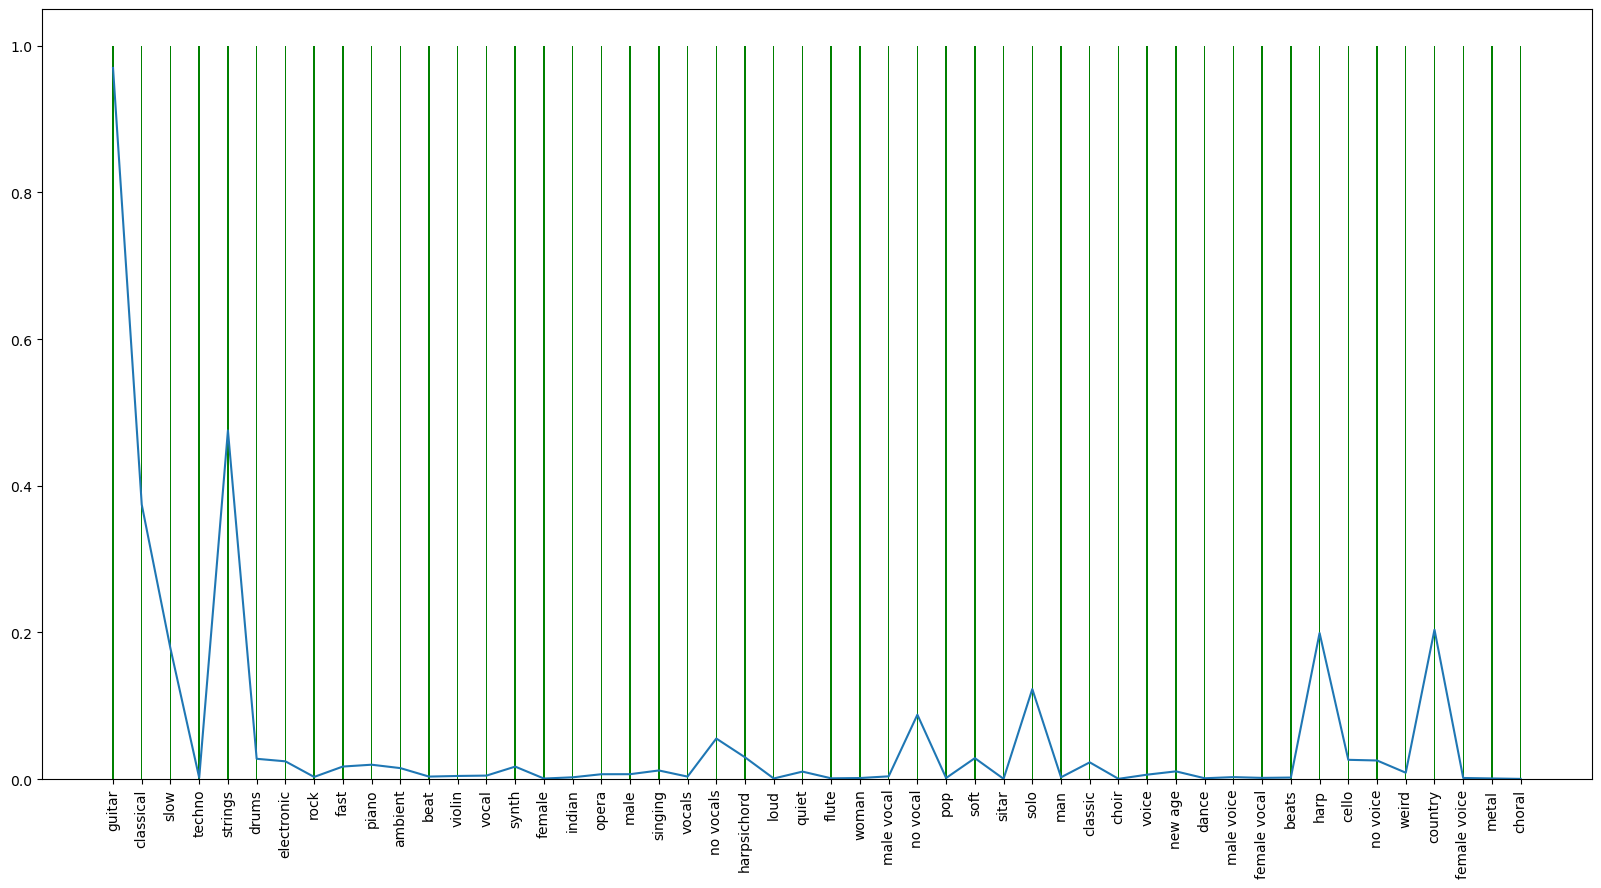

In [42]:
# visual inspection, plot an activation vector v.s. the true labels as a bar chart or similar.

import matplotlib.pyplot as plt

sample_idx = 44  # you can play around with this value :)

activation = detected_tags[sample_idx]
true_labels = test_targs[sample_idx]

# YOUR CODE HERE
figure, axis = plt.subplots(figsize=(20,10))

plt.plot(range(len(true_labels)), activation, label="Activation Vectors")
plt.bar(range(len(true_labels)), height=1.0, width=0.05, color='green')

axis.set_xticks(range(len(true_labels)))
axis.set_xticklabels(class_names, rotation = 90)

plt.show()

In [ ]:
# tests # DO NOT COPY OR MODIFY THIS CELL!!

## Task 5: Evaluation (10 Points)

### 5.1 AOC of ROC

Use the detections and targets of the test set to estimate the performance of the trained network using area-under-curve of the ROC (you can use the sklearn implementations). 


In [47]:
from sklearn.metrics import roc_curve, auc

def calc_roc_auc(true_tags, detected_tags, num_classes):
    # Calculate true positive (tpr) and false positive rates (fpr) for applicable thresholds and compute 
    # ROC curve and area under ROC curve. 
    # Since we have a multi-label setup, use micro-average evaluation: count true and false positives for all 
    # classes and all instances, and then calculate the metrics.
    # To get an exhaustive list of thresholds that will result in different values for tpr and fpr, it is most 
    # efficient to use unique values of the detected probabilities. However, you do not have to worry about the 
    # thresholds if you use the sklearn functions.
    
    # YOUR CODE HERE
    true_tags = true_tags.astype(np.int64)

    micro_fpr, micro_tpr, n = roc_curve(true_tags.ravel(), detected_tags.ravel())

    micro_roc_auc = auc(micro_fpr, micro_tpr)

    # return area under curve, true positive rates, and false positive rates (we will use them for plotting)
    return micro_roc_auc, micro_tpr, micro_fpr



In [48]:
final_score, micro_tpr, micro_fpr = calc_roc_auc(test_targs, detected_tags, len(class_names))
print(f'Final AOC-ROC score of trained model: {final_score}')

Final AOC-ROC score of trained model: 0.8999932180668282


In [49]:
# tests # DO NOT COPY OR MODIFY THIS CELL!!

# you should be able to achieve this AOC score
assert final_score > 0.8

print('Public tests successful!')
score = 2.0
print(f"score = {score}")
score

Public tests successful!
score = 2.0


2.0

### 5.2 Plot ROC

Plot an ROC curve for micro-average evaluation of the test detections. The values for the test detections should have been saved in `final_score`, `micro_tpr`, and `micro_fpr` in the previous cells.

In [50]:
def plot_roc_for_class(fpr, tpr, roc_auc):
    import matplotlib.pyplot as plt
    plt.figure()
    # YOUR CODE HERE
    plt.plot([0,1], [0,1], linestyle='solid')

    plt.plot(fpr, tpr, label=('ROC: {:.3f}'.format(roc_auc)))
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.legend()
    plt.show()

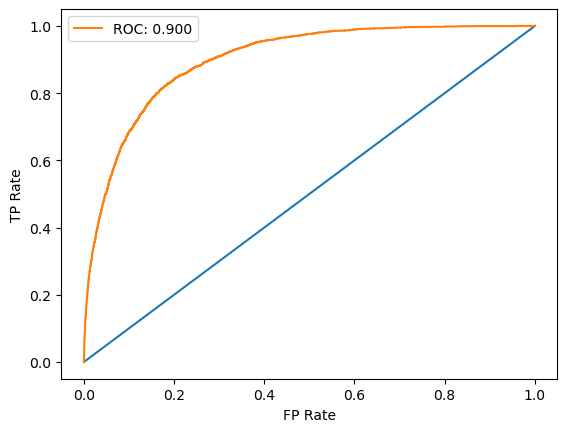

In [51]:
plot_roc_for_class(micro_fpr, micro_tpr, final_score)

In [52]:
# tests # DO NOT COPY OR MODIFY THIS CELL!!


## Congratulations, you are done!

Reminder:
Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).